## Machine Learning
https://www.kaggle.com/datasets/aldinwhyudii/student-depression-and-lifestyle-100k-data

In [1]:
import pandas as pd

dataset = pd.read_csv('student_lifestyle_100k.csv')
dataset['Gender'] = dataset['Gender'].astype('category')
dataset['Department'] = dataset['Department'].astype('category')
dataset['Stress_Level'] = dataset['Stress_Level'].astype('category')


In [9]:
# Aufteilen nach True und False in der Spalte Depression
depressed = dataset[dataset['Depression']]
not_depressed = dataset[~dataset['Depression']]

# 10.000 zufällige negative Stichproben ziehen
not_depressed_sample = not_depressed.sample(n=10062, random_state=42)

# Datensatz zusammensetzen
balanced_dataset = pd.concat([depressed, not_depressed_sample])
# balanced_dataset = balanced_dataset.sample(frac=1, random_state=42).reset_index(drop=True) 

# Aufteilen in Merkmale und Zielvariable und löschen von Student_ID
# data = balanced_dataset.loc[:, 'Age':'Stress_Level']
# target = balanced_dataset['Depression']

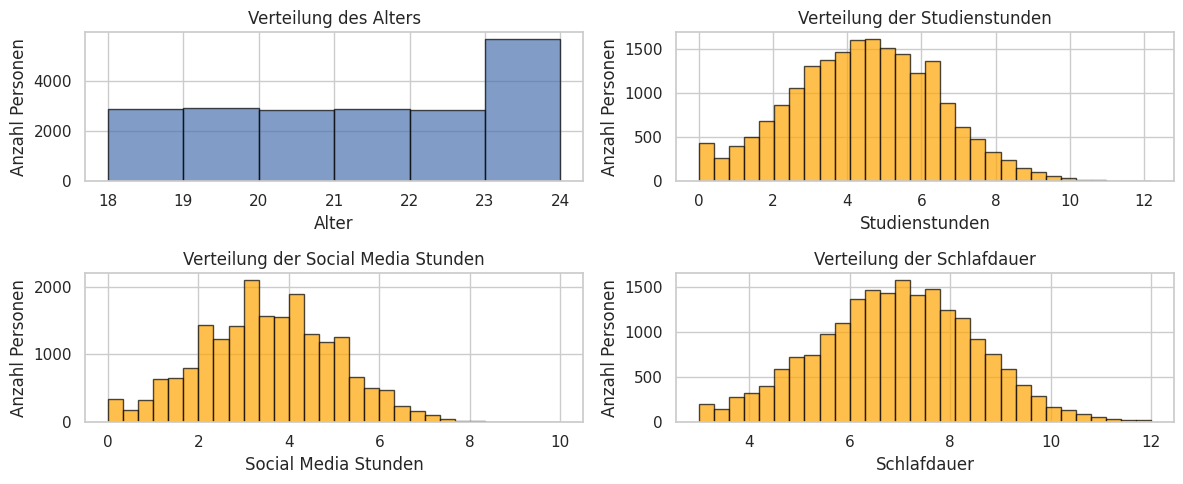

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(2, 2, 1)
plt.hist(balanced_dataset['Age'], bins=6, edgecolor='black', alpha=0.7)
plt.title('Verteilung des Alters')
plt.xlabel('Alter')
plt.ylabel('Anzahl Personen')

plt.subplot(2, 2, 2)
plt.hist(balanced_dataset['Study_Hours'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Verteilung der Studienstunden')
plt.xlabel('Studienstunden')
plt.ylabel('Anzahl Personen')

plt.subplot(2, 2, 3)
plt.hist(balanced_dataset['Social_Media_Hours'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Verteilung der Social Media Stunden')
plt.xlabel('Social Media Stunden')
plt.ylabel('Anzahl Personen')

plt.subplot(2, 2, 4)
plt.hist(balanced_dataset['Sleep_Duration'], bins=30, edgecolor='black', alpha=0.7, color='orange')
plt.title('Verteilung der Schlafdauer')
plt.xlabel('Schlafdauer')
plt.ylabel('Anzahl Personen')

plt.tight_layout()
plt.show()

In [14]:
import seaborn as sns

# sns.set_theme(style="whitegrid")
# sns.pairplot(balanced_dataset, hue="Depression")

Korrelationen zu Depression:
 Depression            1.000000
Social_Media_Hours    0.024778
Student_ID           -0.006937
Age                  -0.008548
Physical_Activity    -0.023565
Study_Hours          -0.027444
Sleep_Duration       -0.089277
CGPA                 -0.284129
Name: Depression, dtype: float64


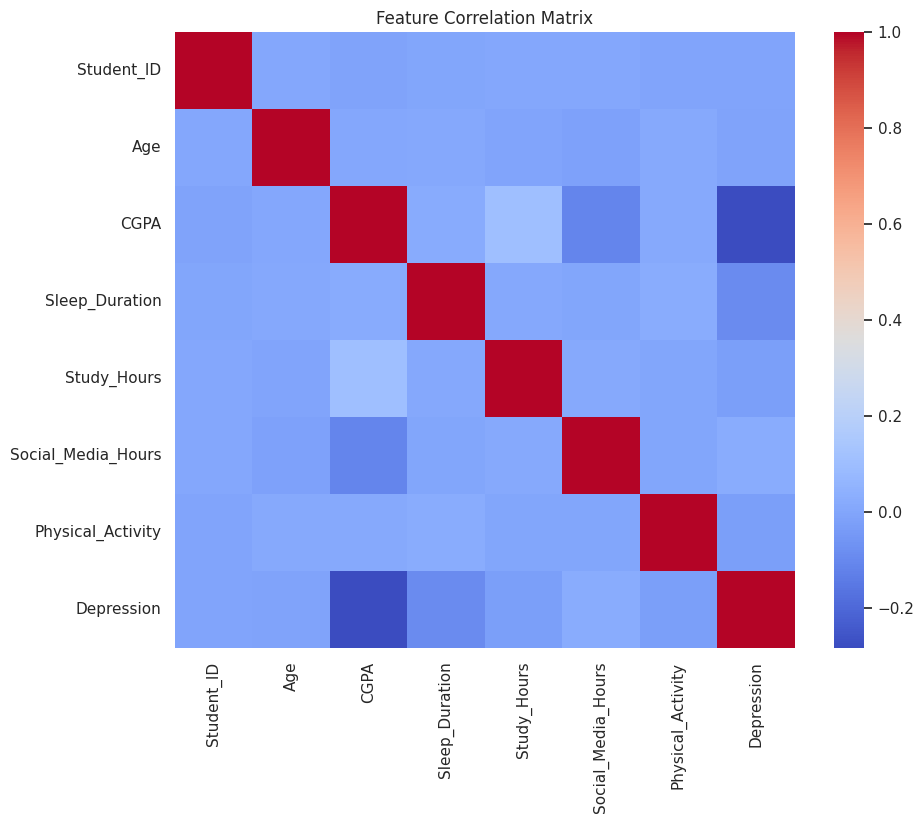

In [15]:
plt.figure(figsize=(10, 8))
# numeric_only=True verhindert den ValueError
correlations = balanced_dataset.corr(numeric_only=True)['Depression'].sort_values(ascending=False)
print("Korrelationen zu Depression:\n", correlations)

sns.heatmap(balanced_dataset.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import torch

data_scaled = RobustScaler().fit_transform(balanced_dataset.drop(columns=['Depression']))
target = balanced_dataset['Depression']

n = len(data_scaled)
input_dim = data_scaled.shape[1]
x = torch.tensor(data_scaled, dtype=torch.float32)
y = torch.tensor(target, dtype=torch.float32).view(-1, 1)

ValueError: Cannot center sparse matrices: use `with_centering=False` instead. See docstring for motivation and alternatives.

In [ ]:
from datetime import datetime

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f'./data/machine_learning/runs/run_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

ids = torch.randperm(len(x))
train_ids = ids[:int(n * .6)]
val_ids = ids[int(n * .6):int(n * .8)]
test_ids = ids[int(n * .8):]

train_dataset = TensorDataset(x[train_ids], y[train_ids])
val_dataset = TensorDataset(x[val_ids], y[val_ids])
test_dataset = TensorDataset(x[test_ids], y[test_ids])

batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True  # Shuffle training data each epoch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle validation
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle test
)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

model = RegressionMLP(input_dim=input_dim)

# Log the model architecture to TensorBoard
writer.add_graph(model, x[train_ids][:batch_size])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
